![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Text Mining: Models and Algorithms

## Problem Set 1

### Import Functions


In [13]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import os
import seaborn as sns
import statsmodels.api as sm

# ML Functions
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error

# NLP functions
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
lemmatizer = WordNetLemmatizer()

import spacy
sp = spacy.load('en_core_web_sm')

import re
from nltk.corpus import stopwords

import warnings
# Ignore SettingWithCopyWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

### Create DataFrames

In [15]:
barcelona_p1 = pd.DataFrame(pd.read_csv('./Barcelona_Data_06-08.csv'))
barcelona_p2 = pd.DataFrame(pd.read_csv('./Barcelona_Data_13-15_06.csv'))
control_p1 = pd.DataFrame(pd.read_csv('./Madrid_Data_06-08.csv'))
control_p2 = pd.DataFrame(pd.read_csv('./Madrid_Data_13-15_06.csv'))

In [16]:
control_p1.shape

(975, 6)

### Dummy variables

In [17]:
barcelona_p1['Treatment_period'] = 0
barcelona_p2['Treatment_period'] = 1
control_p1['Treatment_period'] = 0
control_p2['Treatment_period'] = 1

barcelona_p1['Treatment_city'] = 1
barcelona_p2['Treatment_city'] = 1
control_p1['Treatment_city'] = 0
control_p2['Treatment_city'] = 0

### Concatenate the Dataframes

In [18]:
df = pd.concat([barcelona_p1, barcelona_p2, control_p1, control_p2])

### Exploratory Data Analysis

In [19]:
# Create a new column for combined treatment condition
df['Treatment_condition'] = df['Treatment_period'] * 2 + df['Treatment_city']
df['Price'] = pd.to_numeric(df['Price'].str.replace('€', '').str.replace('.', ''), errors='coerce')
mapping = {0: 'Control_city_p1', 1: 'Treatment_city_p1', 2:'Control_city_p2', 3:'Treatment_city_p2'}
df['Treatment_city_and_treatment'] = df['Treatment_condition'].map(mapping)
df = df.drop('Treatment_condition', axis = 1)

In [20]:
df

,Unnamed: 0,Hotels,Ratings,Price,Link,Descriptions,Treatment_period,Treatment_city,Treatment_city_and_treatment
0,0,Mayerling Bisbe Urquinaona,"8,0",443,https://www.booking.com/hotel/es/chic-basic-ur...,El Mayerling Bisbe Urquinaona ofrece WiFi grat...,0,1,Treatment_city_p1
1,1,Hotel Arts Barcelona,"8,4",1189,https://www.booking.com/hotel/es/arts-barcelon...,Este hotel de diseño tiene vistas a la playa d...,0,1,Treatment_city_p1
2,2,Pensión Coral,"7,8",194,https://www.booking.com/hotel/es/pensia3n-cora...,Esta pensión se encuentra detrás de la plaza d...,0,1,Treatment_city_p1
3,3,Hotel Peninsular,"7,0",270,https://www.booking.com/hotel/es/peninsular-ba...,Este hotel encantador está situado a pocos min...,0,1,Treatment_city_p1
4,4,H Regas Adults Only,"7,5",305,https://www.booking.com/hotel/es/hregas.es.htm...,H Regas Adults Only ofrece habitaciones con ai...,0,1,Treatment_city_p1
...,...,...,...,...,...,...,...,...,...
820,820,Room Plaza España,"8,7",260,https://www.booking.com/hotel/es/room-plaza-es...,"Room Plaza España está en el centro de Madrid,...",1,0,Control_city_p2
821,821,Hostal La Casa de La Plaza,"7,2",247,https://www.booking.com/hotel/es/hostal-la-cas...,Este establecimiento ofrece una buena relación...,1,0,Control_city_p2
822,822,Hostal Regio,"8,0",246,https://www.booking.com/hotel/es/hostal-regio....,El Hostal Regio se encuentra en una calle tran...,1,0,Control_city_p2
823,823,Far Home Atocha,"8,5",240,https://www.booking.com/hotel/es/no-name-city-...,El Far Home Atocha está situado en el centro d...,1,0,Control_city_p2


### Plotting Prices with the different Treatment conditions

- Treated city in treatment Period
- Control city in Treatment period
- Treated city in Control Period
- Control city in Control Period

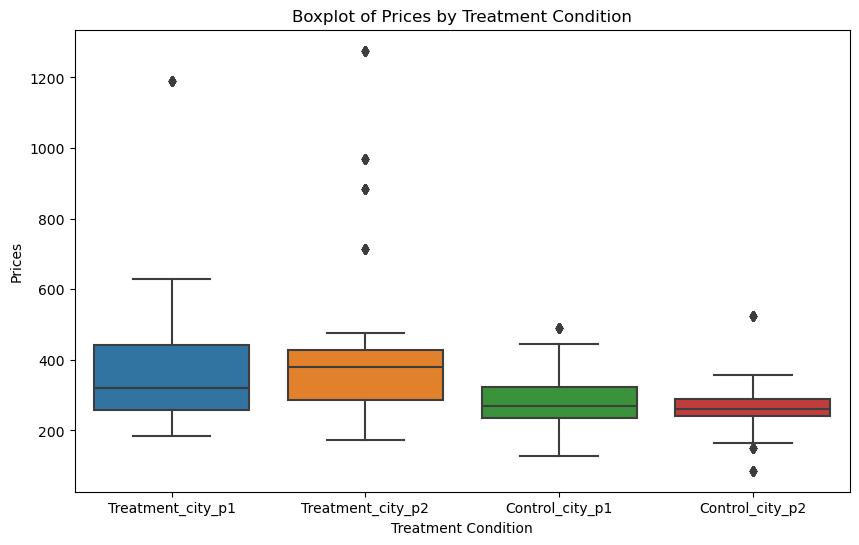

In [21]:
# Create a boxplot with conditional grouping
plt.figure(figsize=(10, 6))
sns.boxplot(data = df, x ='Treatment_city_and_treatment', y = 'Price')

# Add labels and title
plt.xlabel('Treatment Condition')
plt.ylabel('Prices')
plt.title('Boxplot of Prices by Treatment Condition')

# Show the plot
plt.show()

### Average Prices

In [22]:
average_prices = df.groupby('Treatment_city_and_treatment')['Price'].mean()
average_prices

Treatment_city_and_treatment
Control_city_p1      284.920000
Control_city_p2      262.280000
Treatment_city_p1    374.038462
Treatment_city_p2    437.423077
Name: Price, dtype: float64

### Regressions

#### Regression based on city

In [23]:
# Regression with only "treatment period" dummy
X1 = sm.add_constant(df['Treatment_city'])
model1 = sm.OLS(df['Price'], X1)
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     527.9
Date:                Mon, 22 Jan 2024   Prob (F-statistic):          2.10e-109
Time:                        17:06:05   Log-Likelihood:                -24620.
No. Observations:                3750   AIC:                         4.924e+04
Df Residuals:                    3748   BIC:                         4.926e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            274.5433      4.051     67.

#### Regression based on treatment period

In [24]:
# Regression with only "treatment period" dummy
X1 = sm.add_constant(df['Treatment_period'])
model1 = sm.OLS(df['Price'], X1)
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     14.98
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           0.000110
Time:                        17:06:06   Log-Likelihood:                -24860.
No. Observations:                3750   AIC:                         4.972e+04
Df Residuals:                    3748   BIC:                         4.974e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              330.9166      4.081  

#### Regression Based on city and Treatment Period

In [25]:
import statsmodels.api as sm
# Regression with both "treatment period" and "treatment city" dummies and their interaction
df['Interaction_term'] = df['Treatment_period'] * df['Treatment_city']
X3 = sm.add_constant(df[['Treatment_period', 'Treatment_city', 'Interaction_term']])
model3 = sm.OLS(df['Price'], X3)
results3 = model3.fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     204.5
Date:                Mon, 22 Jan 2024   Prob (F-statistic):          8.07e-123
Time:                        17:06:07   Log-Likelihood:                -24583.
No. Observations:                3750   AIC:                         4.917e+04
Df Residuals:                    3746   BIC:                         4.920e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              284.9200      5.451  

### Explanation

The coefficient 'Interaction Term' represents the difference-in-differences (DiD) estimate. 
It captures the differential effect of the treatment on prices by considering the interaction between "treatment period" and "treatment city." The DiD method helps control for time-invariant factors and isolates the impact of the treatment by comparing the changes in the treatment city to the changes in the control city over time.

The need for a second city (control city) is crucial in DiD analysis to create a counterfactual. The control city allows us to account for trends or factors affecting both the treatment and control groups similarly. The interaction term (Treatment_period × Treatment_city) captures the differential effect by considering how the treatment effect varies across the treatment and control groups.

Since the results show that there is a high, positive and significant coefficient this shows that there is a substantially positive effect of treatment on prices.

## NLP

### Analyzing Descriptions

In [ ]:
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

In [ ]:
filename = 'Barcelona_Data_Sonar.csv'
df = pd.read_csv(filename)

text_column = 'Descriptions'

# Remove special characters and numbers
# df['processed_text'] = df[text_column].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# OR (if you want to keep numbers)
df['processed_text'] = df[text_column].apply(lambda x: re.sub(r'\W', ' ', x))

# Convert each word using abbr_or_lower function
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join(abbr_or_lower(word) for word in x.split()))

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Apply stemming
stemmer = PorterStemmer()
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

print(df['processed_text'])

0      abac restaur hotel barcelona gl monumento se e...
1      el barcelona edit se encuentra en barcelona di...
2      el catalonia sagrada familia se halla 15 minut...
3      el hotel lleó se encuentra junto la plaza de c...
4      el catalonia albeniz ofrec habitacion amplia c...
                             ...                        
905    est establecimiento se encuentra en la rambla ...
906    la casa balm es un bed breakfast con conexión ...
907    est hotel moderno ofrec conexión internet por ...
908    el stylish apart es un alojamiento independien...
909    hotel paxton barcelona se encuentra en barcelo...
Name: processed_text, Length: 910, dtype: object


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


# Create document term matrix using CountVectorizer
vectorizer = CountVectorizer(ngram_range = (1,2), min_df=0.22, max_df=0.25)
X = vectorizer.fit_transform(df['processed_text'])

# Convert DTM to DataFrame
dtm_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
display(dtm_df)
dtm_df.shape

,aparcamiento,avenida,cerca,dispon de,dond,el aeropuerto,el centro,en el,escritorio,están equipada,...,lugar,minibar caja,parada,por,presentan,sagrada,sagrada familia,tren,un bar,vista la
0,0,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,1,0,1,1,...,0,0,1,0,0,4,4,2,1,0
3,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,0,0,0,1,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,1
906,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
907,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
908,0,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1


(910, 26)